In [11]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d 
import matplotlib.pyplot as plt
import pprint
inter = interp1d

In [12]:
def get_fac(wavelength, filter_df):
    """
    Gets the factor filter scales a particular wavelength by,
    or interpolate for the factor if wavelength factor is not explicitly
    provided by filter.
    """
    #print "wavelength {}".format(wavelength)
    fac = filter_df[filter_df[0] == wavelength]
    if len(fac) is 0:
        f = inter(filter_df[0], filter_df[1])
        return f(wavelength)
    else:
        return fac[1]

In [13]:
def truncate_spectra_by_sloan_ranges(spectra):
    """
    Returns dictionary indexed by sloan filters, 
    with values being ndarray of wavelengths from the spectra
    that falls under the sloan filter range.
    """
    
    sloan_ranges = {
        'u': [2980, 4130],
        'g': [3630, 5830],
        'z': [7730, 11230],
        'r': [5380, 7230],
        'i': [6430, 8630]
    }
    
    def get_range(fil):
        fil_range = spectra[(spectra[0] >= sloan_ranges[fil][0]) & (spectra[0] <= sloan_ranges[fil][1])]
        return fil_range
        
    #get_range = lambda fil: spectra[(spectra[0] > sloan_ranges[fil][0]) & (spectra[0] < sloan_ranges[fil][1])]
    
    return {
        'u': get_range('u'),
        'g': get_range('g'),
        'z': get_range('z'),
        'r': get_range('r'),
        'i': get_range('i')
    }

In [14]:
def scale_within_range(sloan_filter, spectra):
    
    spectra_ranges = truncate_spectra_by_sloan_ranges(spectra)
    in_range = spectra_ranges[sloan_filter]

    if len(in_range) == 0:
        return None
    
    range_filter = pd.read_csv("SLOAN_SDSS_"+sloan_filter+".dat", header=None, delimiter=" ")
    get_filter_fac = lambda w: get_fac(w, range_filter)
    get_filter_facs = np.vectorize(get_filter_fac)
    
    w_factors = get_filter_facs(in_range[0]) # assuming order is the same
    scaled = in_range[1] * w_factors
    return scaled

**Calculation to convert flux values to magnitude, based on Vega System:**

Zero Point: 1568.54 (Jy)



In [15]:
def flux_to_magnitude(flux):
    return 3.639e-9 - 2.5*np.log10(flux/1568.54)

In [16]:
def get_magnitudes_at_epoch(spec_at_epoch):
    spec_at_epoch = spec_at_epoch if type(spec_at_epoch) is str else str(spec_at_epoch)
    
    spectra = pd.read_csv(spec_at_epoch+".csv", header=None, skiprows=[0], usecols=[0,1])    

    sums = {'u':0,'g':0,'z':0,'r':0,'i':0}
    for f in sums.keys():
        n = scale_within_range(f, spectra)
        if n is not None:
            sums[f] = n.sum()
    
    non_zero_sums = filter(lambda s: s != 0, sums.values())
    f2m = np.vectorize(flux_to_magnitude)
    return np.asarray(f2m(non_zero_sums)) # discards the filter label

In [17]:
spectra_epoch = {
    1: {'epoch': 54361.00, 'magnitudes': None},
    2: {'epoch': 54363.46, 'magnitudes': None},
    3: {'epoch': 54365.38, 'magnitudes': None},
    4: {'epoch': 54376.32, 'magnitudes': None},
    5: {'epoch': 54376.36, 'magnitudes': None},
    6: {'epoch': 54379.44, 'magnitudes': None},
    7: {'epoch': 54381.35, 'magnitudes': None},
    8: {'epoch': 54381.35, 'magnitudes': None},
    9: {'epoch': 54389.28, 'magnitudes': None},
    10: {'epoch': 54408.21, 'magnitudes': None},
    11: {'epoch': 54408.25,  'magnitudes': None}
}

for i in xrange(1, 12):
    spectra_epoch[i]['magnitudes'] = get_magnitudes_at_epoch(i)

**Epoch and corresponding magnitudes computed:**

In [18]:
pprint.pprint(spectra_epoch)

{1: {'epoch': 54361.0,
     'magnitudes': array([ 43.3579957 ,  41.82699181,  42.54314628,  42.89885261,  40.41144479])},
 2: {'epoch': 54363.46,
     'magnitudes': array([ 42.20200533,  40.70051628,  43.17779378,  40.35849921])},
 3: {'epoch': 54365.38,
     'magnitudes': array([ 40.09553064,  39.11365205,  42.06157201,  43.07551832,  39.23080431])},
 4: {'epoch': 54376.32,
     'magnitudes': array([ 43.3383245 ,  44.77281648,  41.77518859])},
 5: {'epoch': 54376.36,
     'magnitudes': array([ 44.05858512,  42.6935816 ,  46.26484721,  44.05102339])},
 6: {'epoch': 54379.44,
     'magnitudes': array([ 42.87919842,  40.91874633,  44.4676811 ,  40.93817928])},
 7: {'epoch': 54381.35,
     'magnitudes': array([ 41.7624845 ,  45.87949735,  41.41258746])},
 8: {'epoch': 54381.35,
     'magnitudes': array([ 42.95018708,  43.18175888,  44.79768148])},
 9: {'epoch': 54389.28,
     'magnitudes': array([ 45.12900785,  43.66227456,  48.84762937,  47.51948166,  43.98571542])},
 10: {'epoch': 54408

In [28]:
epochs = [spectra_epoch[x]['epoch'] for x in xrange(1,12)]
magnitudes = [spectra_epoch[x]['magnitudes'] for x in xrange(1,12)]

In [44]:
scale_fac = 2.3
for epoch in xrange(11):
    plt.scatter([epochs[epoch]]*len(magnitudes[epoch]), magnitudes[epoch]/scale_fac)

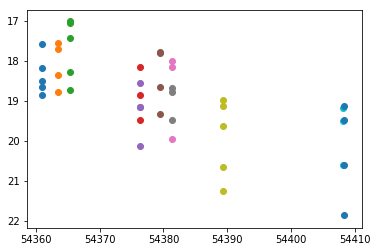

In [43]:
plt.gca().invert_yaxis()

plt.show()